$$ Sentiment Analysis from Amazon Movie Reviews $$

In [1]:
# Call in necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [2]:
# Bring in the data files
df_train = pd.read_csv("df_train_preprocessed.csv")
df_train.columns
df_test = pd.read_csv("test.csv")

In [3]:
# Merge the train and test files on 'Id'; drop unnecessary columns.
X_test = pd.merge(df_train, df_test, left_on='Id', right_on='Id')
X_test = X_test.drop(columns=['Score_x'])
X_test = X_test.rename(columns={'Score_y': 'Score'})

X_test.to_csv("X_submission_df.csv", index=False)

X_train = df_train[df_train['Score'].notnull()]
X_train.to_csv("X_train_df.csv", index=False)

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

In [4]:
#combine them back for resampling only the *training data*
train_data = pd.concat([X_train, Y_train], axis=1)

#separate minority and majority classes
Fives = train_data[train_data.Score==5]
Fours = train_data[train_data.Score==4]
Threes = train_data[train_data.Score==3]
Twos = train_data[train_data.Score==2]
Ones = train_data[train_data.Score==1]

#Downsample majority
Fives_downsampled = resample(Fives, replace=False, n_samples=len(Twos), random_state=27)
Fours_downsampled = resample(Fours, replace=False, n_samples=len(Twos), random_state=27)
Threes_downsampled = resample(Threes, replace=False, n_samples=len(Twos), random_state=27)
Ones_downsampled = resample(Ones, replace=False, n_samples=len(Twos), random_state=27)
#Combine minority and downsample majority
downsampled = pd.concat([Twos, Ones_downsampled, Threes_downsampled, Fours_downsampled, Fives_downsampled])
Y_train = downsampled['Score']

# Process the DataFrames
X_submission = pd.read_csv("X_submission_df.csv")
X_train_processed = downsampled.drop(columns=['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Score', 'Text', 'Text_wo_stop'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Text_wo_stop'])
X_submission_processed = X_submission.drop(columns=['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Score', 'Text', 'Text_wo_stop'])
print(X_train_processed.cleaned_text)

189478     stay away...scen missing... [mi copi korean le...
1171529    ignor harsh review go see mulder sculli back a...
932455     good french cinema undeni exist (the polish-fr...
1618463    girl realli skinny, someon pleas give someth e...
1546081    here' honest review clear glass vs. rosey glas...
                                 ...                        
92120                          vh dvd. alway love movi form.
694474     movi sear brutal honest! fear inher world, cau...
866099     tackl sticki subject, keep charact develop blo...
44711      great movie. enjoy pacino role blind person. l...
94572      movi includ redemption, sports, cheech marin g...
Name: cleaned_text, Length: 315325, dtype: object


## Term Frequency- Inverse Document Frequency (TF IDF)

In [5]:
# Assigns importance to keywords based on # of times it appears in the document.
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,3))

features = tfidf.fit_transform(X_train_processed.cleaned_text.astype('U'))#.toarray()
labels = downsampled['Score']

features_test =  tfidf.transform(X_test_processed.cleaned_text.astype('U'))
features_submission =  tfidf.transform(X_submission_processed.cleaned_text.astype('U'))

## Logistic Regression

Wall time: 1min 54s
             Id  Score
0             5    5.0
1            11    4.0
2            17    4.0
3            46    5.0
4            47    3.0
...         ...    ...
299995  1697520    2.0
299996  1697522    5.0
299997  1697524    1.0
299998  1697527    4.0
299999  1697528    1.0

[300000 rows x 2 columns]
RMSE on testing set =  1.0758849861470474
58.46%


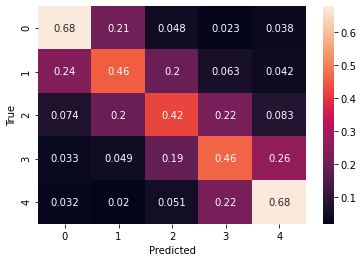

In [6]:
# Create a Logistic Regression Model

clf_log_reg = LogisticRegression(random_state=0, solver="sag", multi_class='multinomial') #sag solver recommended for lots of data
%time clf_log_reg.fit(features, labels)

clf_log_reg.score(features, labels)

#Make predictions with X_test and the set with the missing scores.
X_reg_submission = X_submission
Y_test_predictions_reg = (clf_log_reg.predict(features_test))
X_reg_submission['Score'] = (clf_log_reg.predict(features_submission)) #X_submission['Score']
submission_reg = X_reg_submission[['Id', 'Score']]
print(submission_reg)
submission_reg.to_csv("Log_Reg.csv", index=False)

#Evaluate your model on the testing set
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions_reg))

#predicted = clf.predict(features_test)
accuracy_score_reg = metrics.accuracy_score(Y_test_predictions_reg, Y_test)
print(str('{:04.2f}'.format(accuracy_score_reg*100))+'%')

#Plot a confusion matrix
cm_reg = confusion_matrix(Y_test, Y_test_predictions_reg, normalize='true')
sns.heatmap(cm_reg, annot=True)
#plt.title("Confusion matrix of the classifier")
plt.xlabel('Predicted')
plt.ylabel("True")
plt.show()